In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data preprocessing

1. Reading the dataset, here is the data from 2014 jan 1 to 2023 dec 31
2. Getting the basic info about the dataset like its shape, mean, std and etc.
3. Reformatting values to float from str
4. Visualizing what we have at this point of research

In [25]:
df = pd.read_csv("/Users/zafiraibraeva/Code/uni coding/thesis/thesis_code/thesis/data/merged_hajnal_data.csv")
df.head()

,Date,CO,NO2,NOx,PM10,SO2
0,2019-01-01 00:00:00,NaN,25.3,62.2,18.0,2.2
1,2019-01-02 00:00:00,NaN,24.1,40.2,10.0,2.0
2,2019-01-03 00:00:00,NaN,21.5,38.0,10.0,2.3
3,2019-01-04 00:00:00,NaN,31.7,77.1,19.0,2.9
4,2019-01-05 00:00:00,NaN,26.5,56.4,22.0,3.7


In [26]:
df.shape

(3609, 6)

In [27]:
df.describe()

,CO,NO2,NOx,PM10,SO2
count,3130.000000,3072.000000,3072.00000,3485.000000,2926.000000
mean,512.218530,33.390397,68.83890,26.468293,3.618592
std,256.933855,13.388188,41.90604,16.459006,1.988678
min,26.000000,5.100000,9.00000,5.000000,0.500000
25%,344.000000,23.600000,38.00000,16.000000,2.200000
50%,449.000000,32.200000,60.10000,22.000000,3.100000
75%,618.000000,41.200000,88.22500,32.000000,4.500000
max,3453.000000,96.900000,338.20000,248.000000,19.100000


In [28]:
df['Date'] = pd.to_datetime(df['Date'])
df['YearMonth'] = df['Date'].dt.to_period('M')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df.set_index('Date', inplace=True)
df

,CO,NO2,NOx,PM10,SO2,YearMonth,Year,Month
Date,,,,,,,,
2019-01-01,NaN,25.3,62.2,18.0,2.2,2019-01,2019,1
2019-01-02,NaN,24.1,40.2,10.0,2.0,2019-01,2019,1
2019-01-03,NaN,21.5,38.0,10.0,2.3,2019-01,2019,1
2019-01-04,NaN,31.7,77.1,19.0,2.9,2019-01,2019,1
2019-01-05,NaN,26.5,56.4,22.0,3.7,2019-01,2019,1
...,...,...,...,...,...,...,...,...
2014-12-27,611.0,21.0,38.9,20.0,5.9,2014-12,2014,12
2014-12-28,686.0,15.7,28.7,31.0,6.1,2014-12,2014,12
2014-12-29,595.0,15.9,24.0,24.0,6.5,2014-12,2014,12


In [29]:
non_group_cols = [col for col in df.columns if col not in ['YearMonth', 'Year', 'Month']]

monthly_stats = df.groupby('YearMonth')[non_group_cols].apply(lambda x: x.describe())
print("Monthly statistics: ")
print(monthly_stats)

Monthly statistics: 
                          CO        NO2         NOx       PM10        SO2
YearMonth                                                                
2014-01   count    29.000000  18.000000   18.000000  31.000000  14.000000
          mean    839.068966  37.816667  117.172222  43.677419   8.128571
          std     304.214085   9.048383   51.295830  19.557415   1.786888
          min     289.000000  17.800000   30.700000  17.000000   5.700000
          25%     675.000000  31.450000   86.025000  28.000000   6.575000
...                      ...        ...         ...        ...        ...
2023-12   min     331.000000   9.000000   26.100000   7.000000        NaN
          25%     817.750000  20.500000   48.200000  13.500000        NaN
          50%    1050.000000  24.700000   63.100000  19.000000        NaN
          75%    1136.000000  29.600000   80.600000  24.500000        NaN
          max    1205.000000  43.600000  186.100000  43.000000        NaN

[960 rows x 5 co

In [30]:
nans = df.groupby('Year')[non_group_cols].apply(lambda x: x.isna().sum())
print("NaN values for each year: ")
nans

NaN values for each year: 


,CO,NO2,NOx,PM10,SO2
Year,,,,,
2014,7,25,25,7,37
2015,10,18,18,16,212
2016,0,6,6,11,0
2017,74,6,6,5,2
2018,40,16,16,13,32
2019,154,8,8,1,26
2020,125,10,10,6,32
2021,8,15,15,26,29
2022,16,156,156,27,37


Since for 6 years there was no data for PM2.5, PM2.5 is dropped.

In [31]:
df.drop('YearMonth', axis=1, inplace=True)

In [32]:
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(",", ".")
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.head(8)

,CO,NO2,NOx,PM10,SO2,Year,Month
Date,,,,,,,
2019-01-01,NaN,25.3,62.2,18.0,2.2,2019,1
2019-01-02,NaN,24.1,40.2,10.0,2.0,2019,1
2019-01-03,NaN,21.5,38.0,10.0,2.3,2019,1
2019-01-04,NaN,31.7,77.1,19.0,2.9,2019,1
2019-01-05,NaN,26.5,56.4,22.0,3.7,2019,1
2019-01-06,NaN,17.2,35.6,18.0,2.7,2019,1
2019-01-07,NaN,35.6,84.0,29.0,4.0,2019,1
2019-01-08,NaN,38.1,98.2,36.0,5.6,2019,1


In [33]:
duplicate = df[df.duplicated()]
print("Duplicate data: ")
print(duplicate)

Duplicate data: 
               CO  NO2  NOx  PM10  SO2  Year  Month
Date                                               
2018-08-22    NaN  NaN  NaN   NaN  NaN  2018      8
2018-08-23    NaN  NaN  NaN   NaN  NaN  2018      8
2023-04-07    NaN  NaN  NaN   NaN  NaN  2023      4
2023-08-26    NaN  NaN  NaN   NaN  NaN  2023      8
2023-09-30  453.0  NaN  NaN  27.0  NaN  2023      9
2022-11-22    NaN  NaN  NaN   NaN  NaN  2022     11
2022-11-23    NaN  NaN  NaN   NaN  NaN  2022     11
2022-11-24    NaN  NaN  NaN   NaN  NaN  2022     11
2020-04-21    NaN  NaN  NaN  17.0  NaN  2020      4
2021-05-11    NaN  NaN  NaN   NaN  NaN  2021      5
2015-07-23    NaN  NaN  NaN   NaN  NaN  2015      7
2015-07-24    NaN  NaN  NaN   NaN  NaN  2015      7
2015-07-25    NaN  NaN  NaN   NaN  NaN  2015      7
2015-07-26    NaN  NaN  NaN   NaN  NaN  2015      7
2015-07-27    NaN  NaN  NaN   NaN  NaN  2015      7
2015-07-28    NaN  NaN  NaN   NaN  NaN  2015      7
2015-07-29    NaN  NaN  NaN   NaN  NaN  2015   

In [34]:
def scatter_pollutants(df):
    num_pollutants = len(df.columns)
    
    nrows = (num_pollutants + 1) // 2 
    fig, axes = plt.subplots(nrows, 2, figsize=(12, nrows * 4)) 
    
    axes = axes.flatten()
    
    for i, column in enumerate(df.columns):
        axes[i].scatter(range(len(df[column])), df[column], alpha=0.7, color='b', s=50)
        axes[i].set_title(f'Scatter Plot of {column} Values')
        axes[i].set_ylabel(column)
    
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

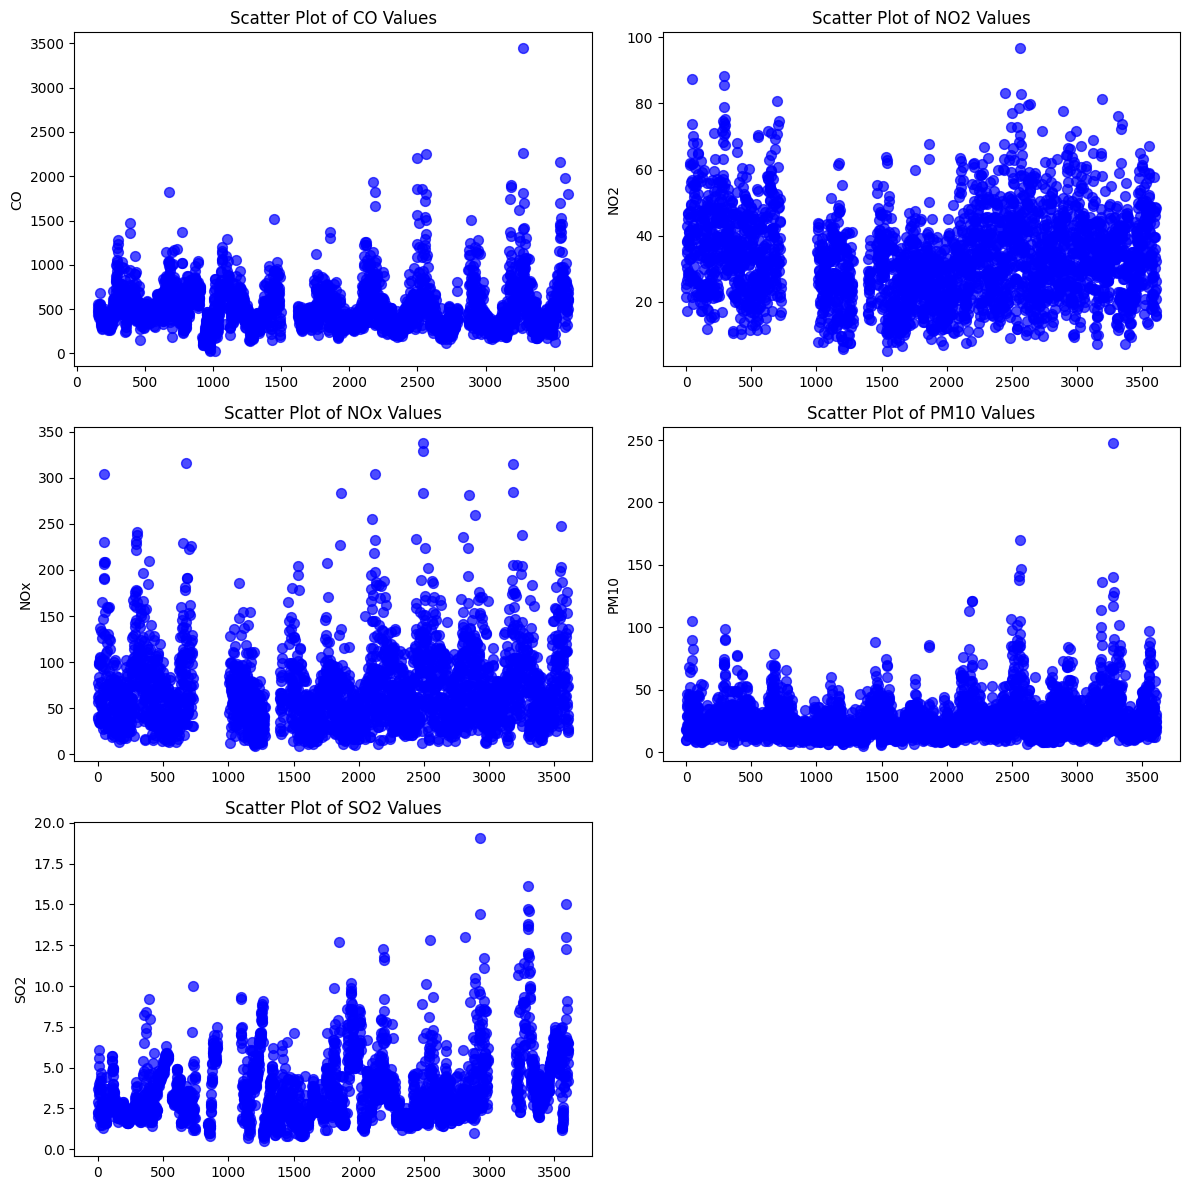

In [35]:
df_subset = df.drop(['Year', 'Month'], axis=1)
scatter_pollutants(df_subset)

## Imputation 

For imputation of NaN values, after researching I found out that RandomForest is the most efficient technique for air quality data.

In [36]:
from sklearn.impute import SimpleImputer

df_imputed = df.copy()

def rf_imputation(df):
    for col in df_imputed.columns:
        if df_imputed[col].isna().sum() > 0:
            train_data = df_imputed[df_imputed[col].notna()]
            test_data = df_imputed[df_imputed[col].isna()]
            
            X_train = train_data.drop(columns=[col])
            y_train = train_data[col]
            
            X_test = test_data.drop(columns=[col])
            
            imputer = SimpleImputer(strategy='mean')
            X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
            X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
            
            if X_train.shape[1] > 0 and not X_test.empty:
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2, random_state=42)
                rf_model.fit(X_train_scaled, y_train)
                
                predictions = rf_model.predict(X_test_scaled)
                df_imputed.loc[df[col].isna(), col] = predictions

    print("Remaining null values: ")
    print(df_imputed.isna().sum())
    
    return df_imputed

rf_imputation(df_imputed)

df_imputed.head(5)

Remaining null values: 
CO       0
NO2      0
NOx      0
PM10     0
SO2      0
Year     0
Month    0
dtype: int64


,CO,NO2,NOx,PM10,SO2,Year,Month
Date,,,,,,,
2019-01-01,507.931556,25.3,62.2,18.0,2.2,2019,1
2019-01-02,376.791835,24.1,40.2,10.0,2.0,2019,1
2019-01-03,382.096194,21.5,38.0,10.0,2.3,2019,1
2019-01-04,547.765121,31.7,77.1,19.0,2.9,2019,1
2019-01-05,519.788784,26.5,56.4,22.0,3.7,2019,1


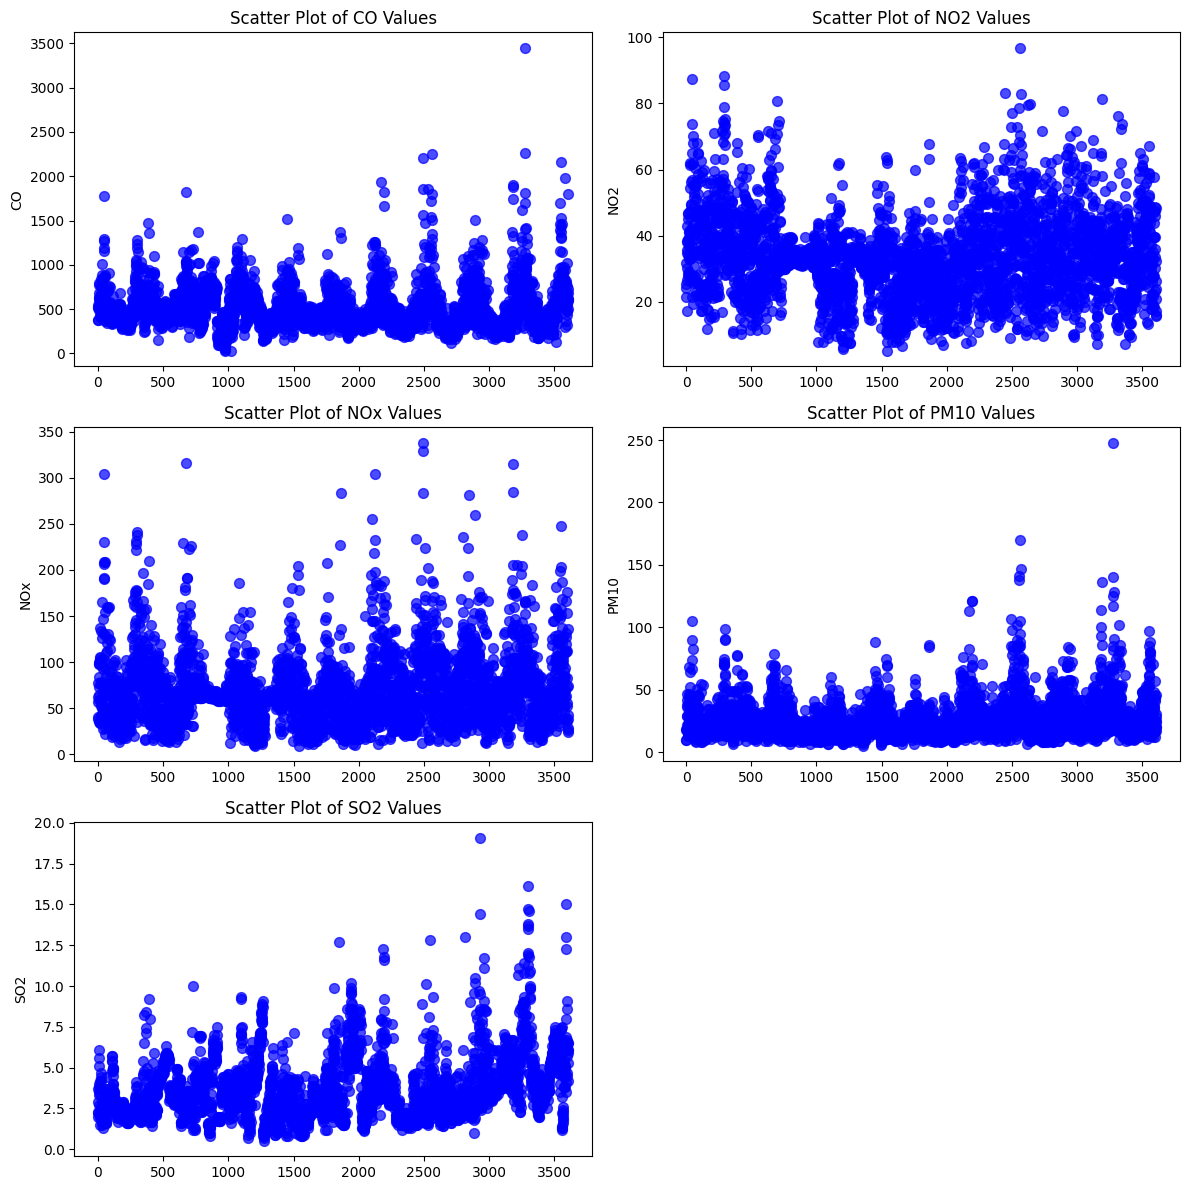

In [37]:
df_subset2 = df_imputed.drop(['Year', 'Month'], axis=1)
scatter_pollutants(df_subset2)

In order to check how good RandomForest works, we will randomly remove some values, impute them with RF and then check results with the real ones. As well as calculating the MAE and RMSE for each pollutant.

In [38]:
for col in df_subset2.columns:
    np.random.seed(42)
    mask = np.random.rand(len(df_subset2)) < 0.1
    original_values = df_subset2.loc[mask, col].copy()
    df_subset2.loc[mask, col] = np.nan
    
    df_subset2 = rf_imputation(df_subset2)
    
    imputed_val = df_subset2.loc[mask, col]
    
    mae = mean_absolute_error(original_values, imputed_val)
    rmse = np.sqrt(mean_squared_error(original_values, imputed_val))
    
    print(f"\nEvaluation for {col}:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Remaining null values: 
CO       0
NO2      0
NOx      0
PM10     0
SO2      0
Year     0
Month    0
dtype: int64

Evaluation for CO:
Mean Absolute Error (MAE): 0.00
Root Mean Squared Error (RMSE): 0.00
Remaining null values: 
CO       0
NO2      0
NOx      0
PM10     0
SO2      0
Year     0
Month    0
dtype: int64

Evaluation for NO2:
Mean Absolute Error (MAE): 2.64
Root Mean Squared Error (RMSE): 3.89
Remaining null values: 
CO       0
NO2      0
NOx      0
PM10     0
SO2      0
Year     0
Month    0
dtype: int64

Evaluation for NOx:
Mean Absolute Error (MAE): 6.05
Root Mean Squared Error (RMSE): 9.74
Remaining null values: 
CO       0
NO2      0
NOx      0
PM10     0
SO2      0
Year     0
Month    0
dtype: int64

Evaluation for PM10:
Mean Absolute Error (MAE): 5.27
Root Mean Squared Error (RMSE): 7.58
Remaining null values: 
CO       0
NO2      0
NOx      0
PM10     0
SO2      0
Year     0
Month    0
dtype: int64

Evaluation for SO2:
Mean Absolute Error (MAE): 0.71
Root Mean Squared

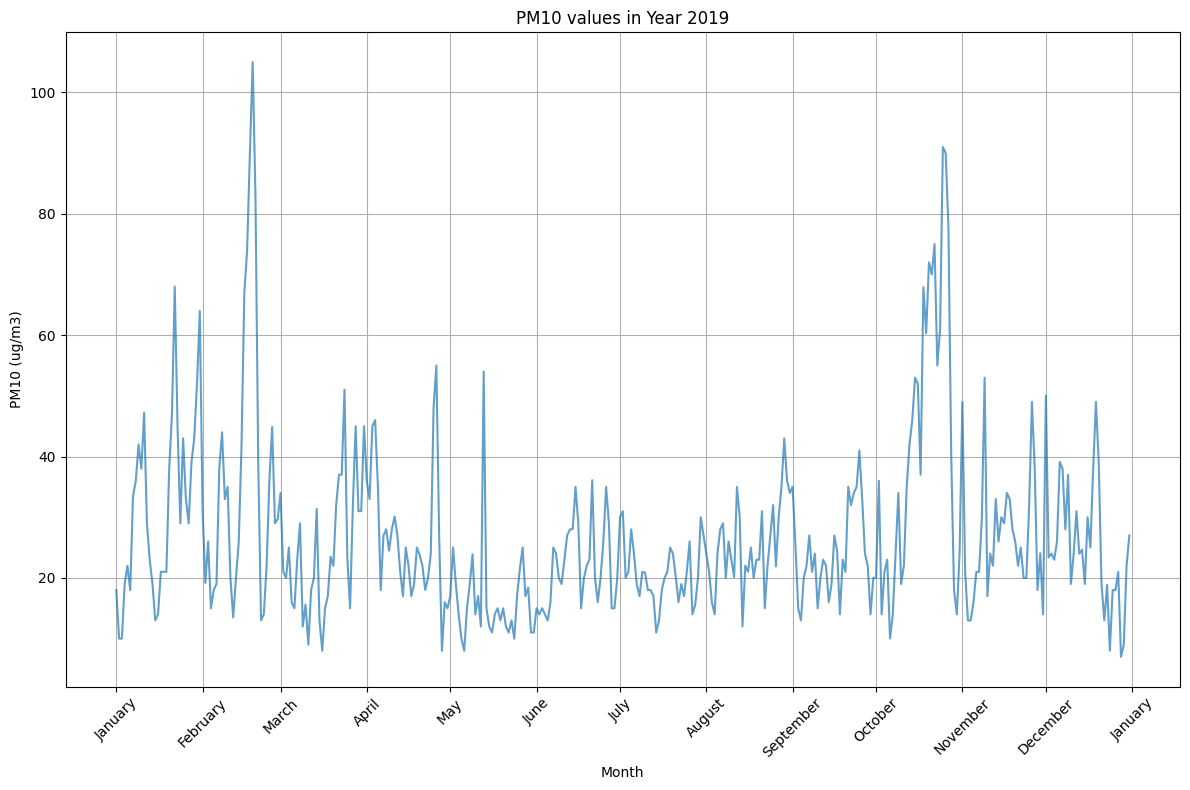

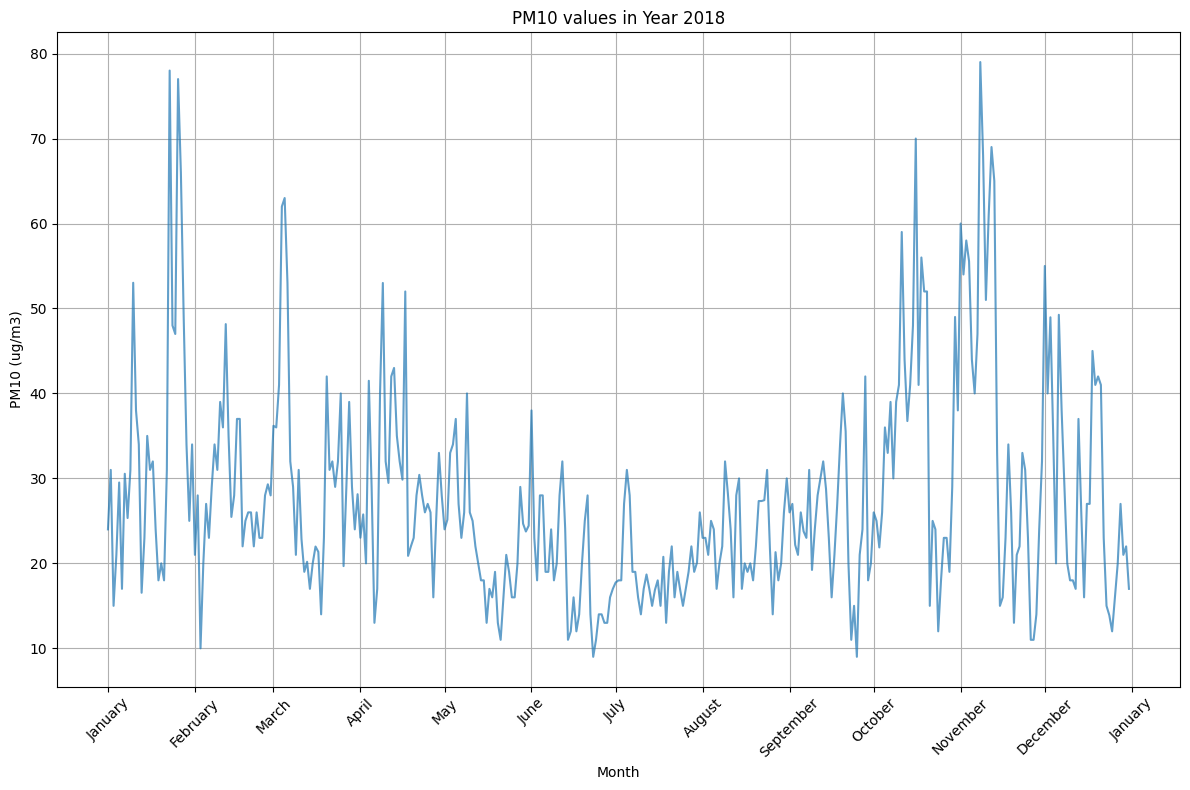

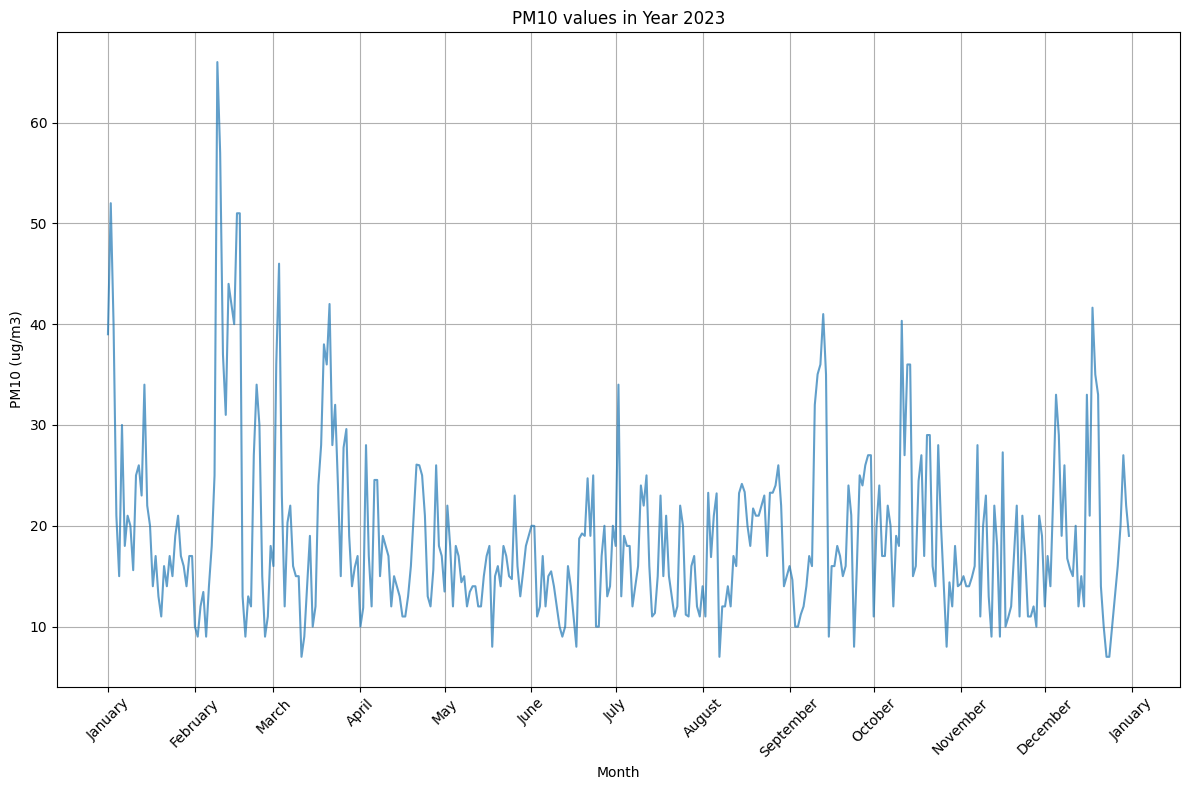

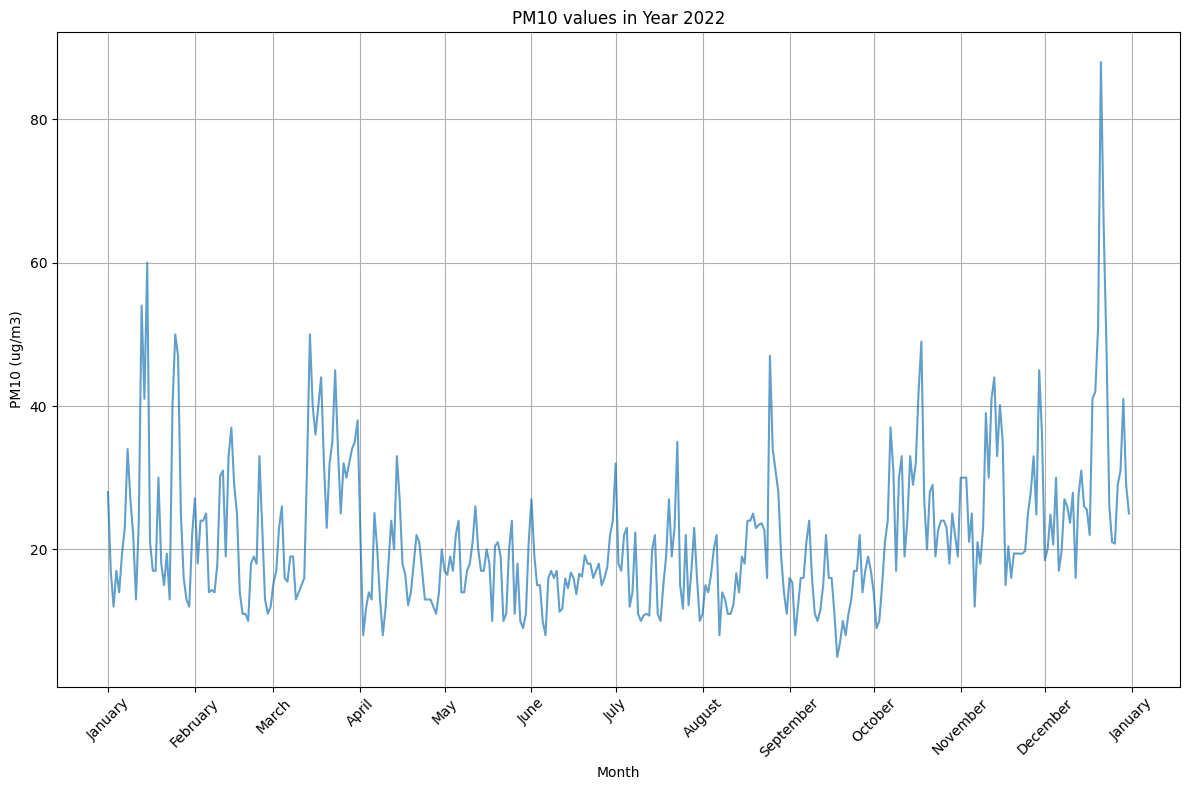

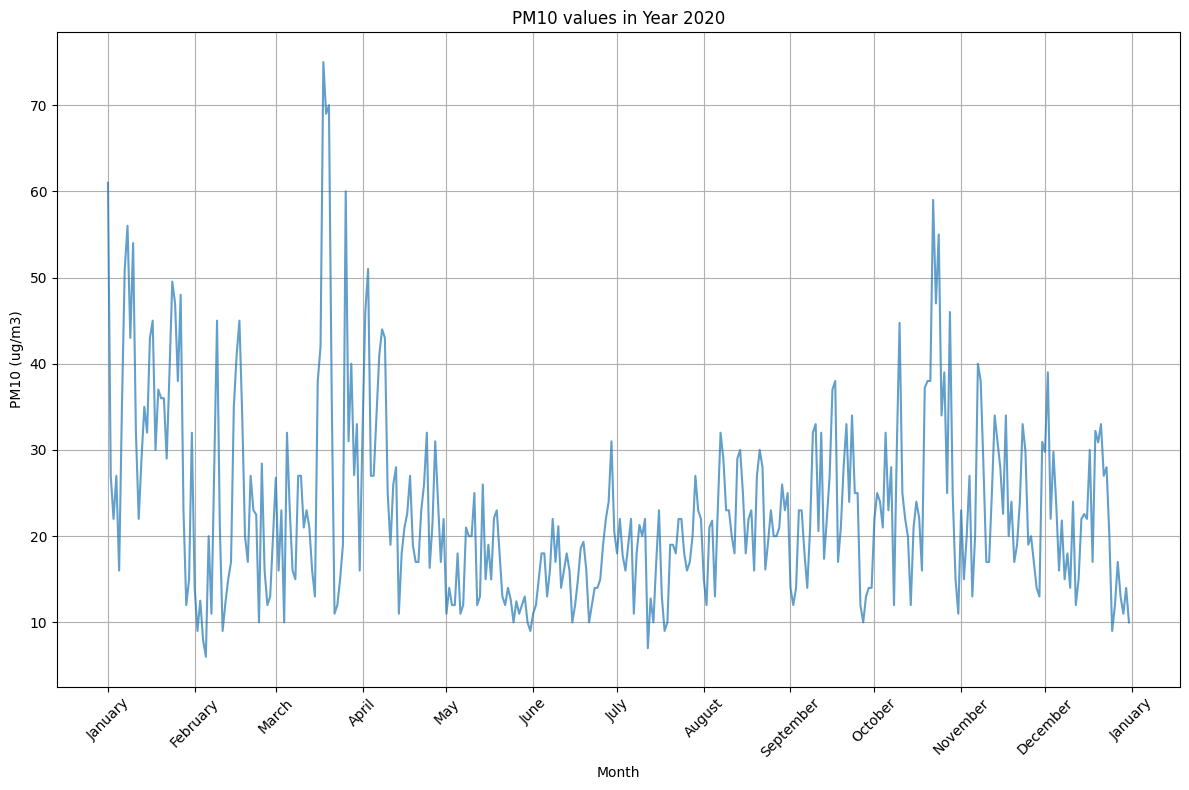

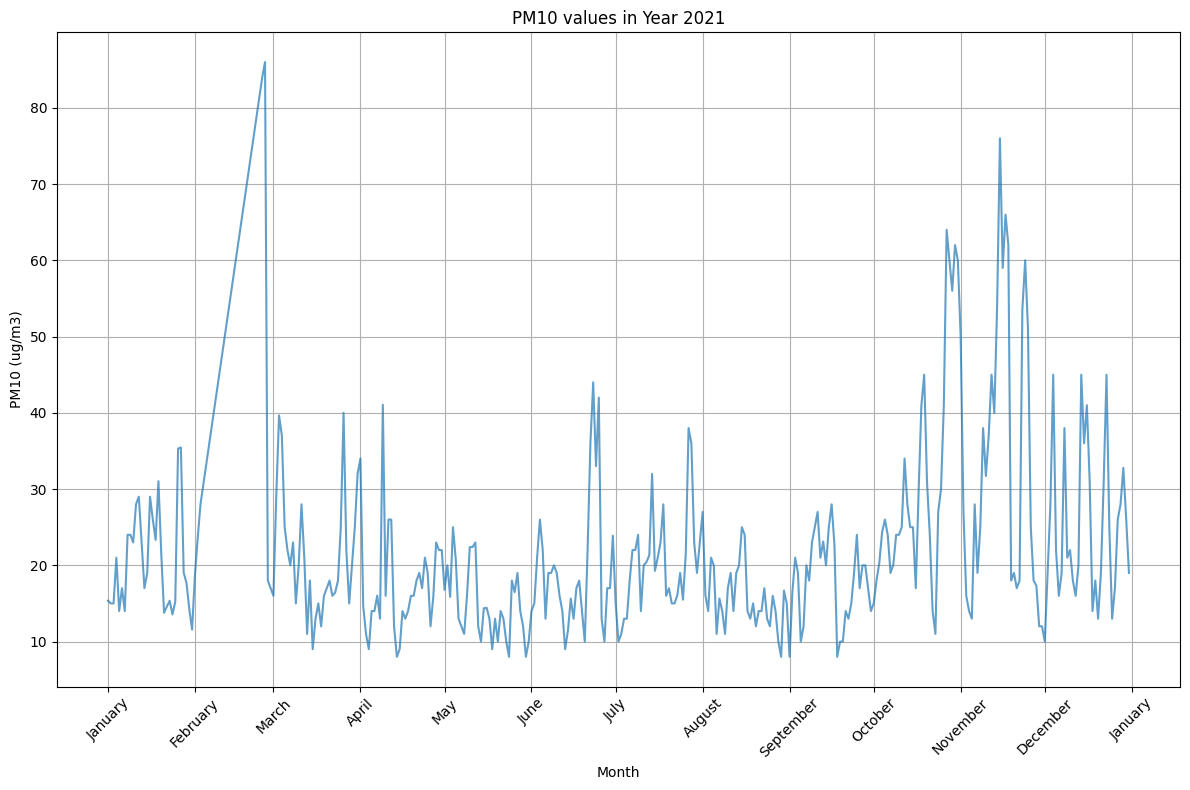

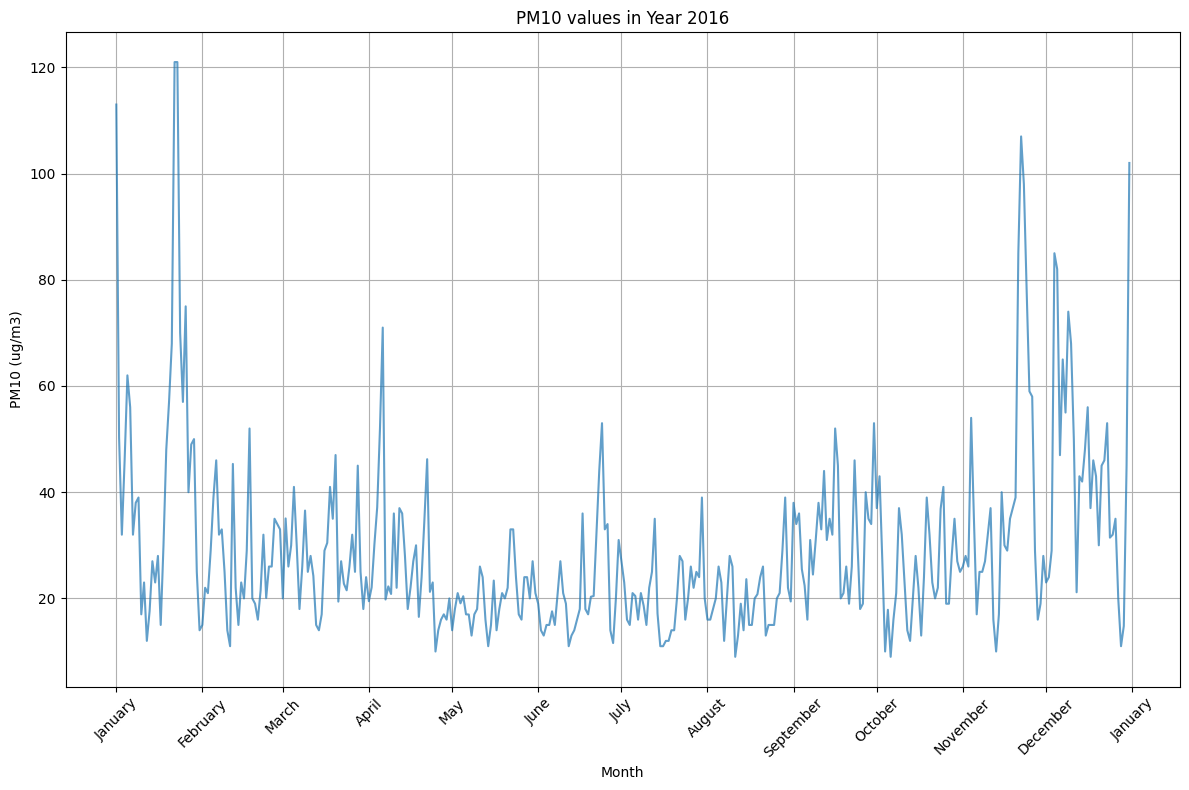

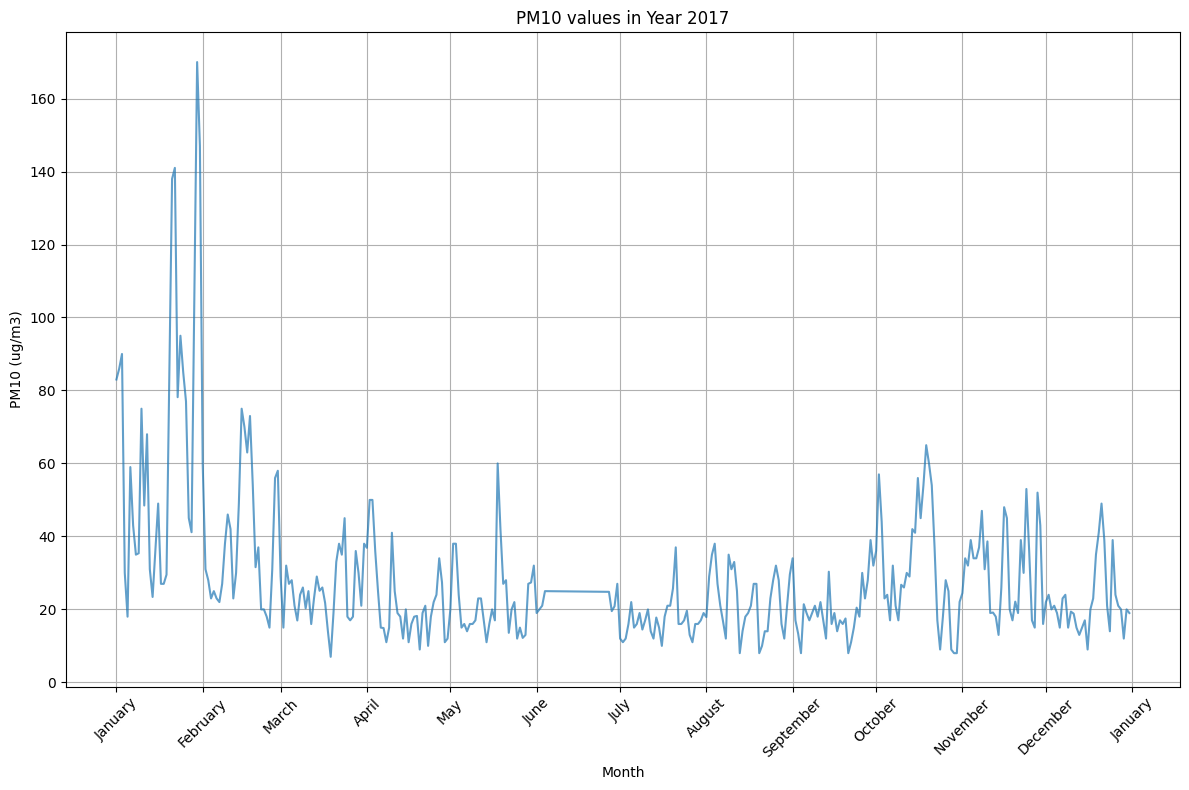

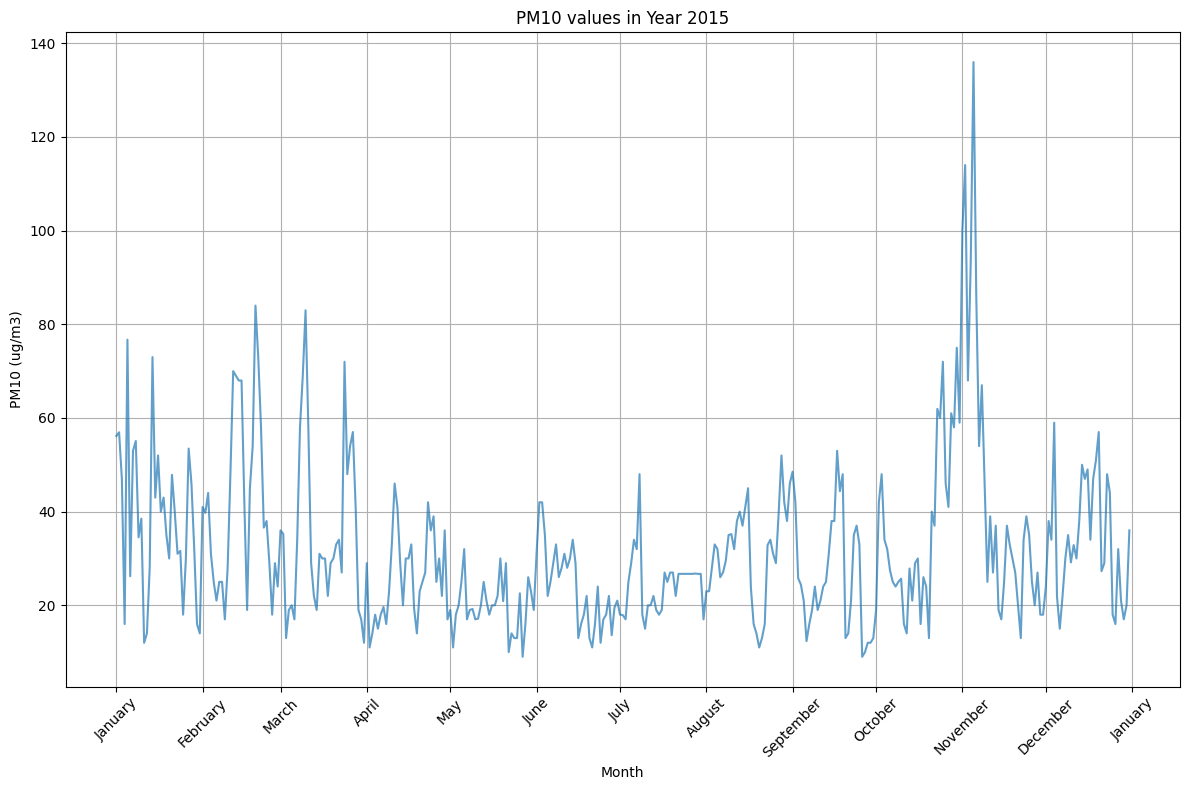

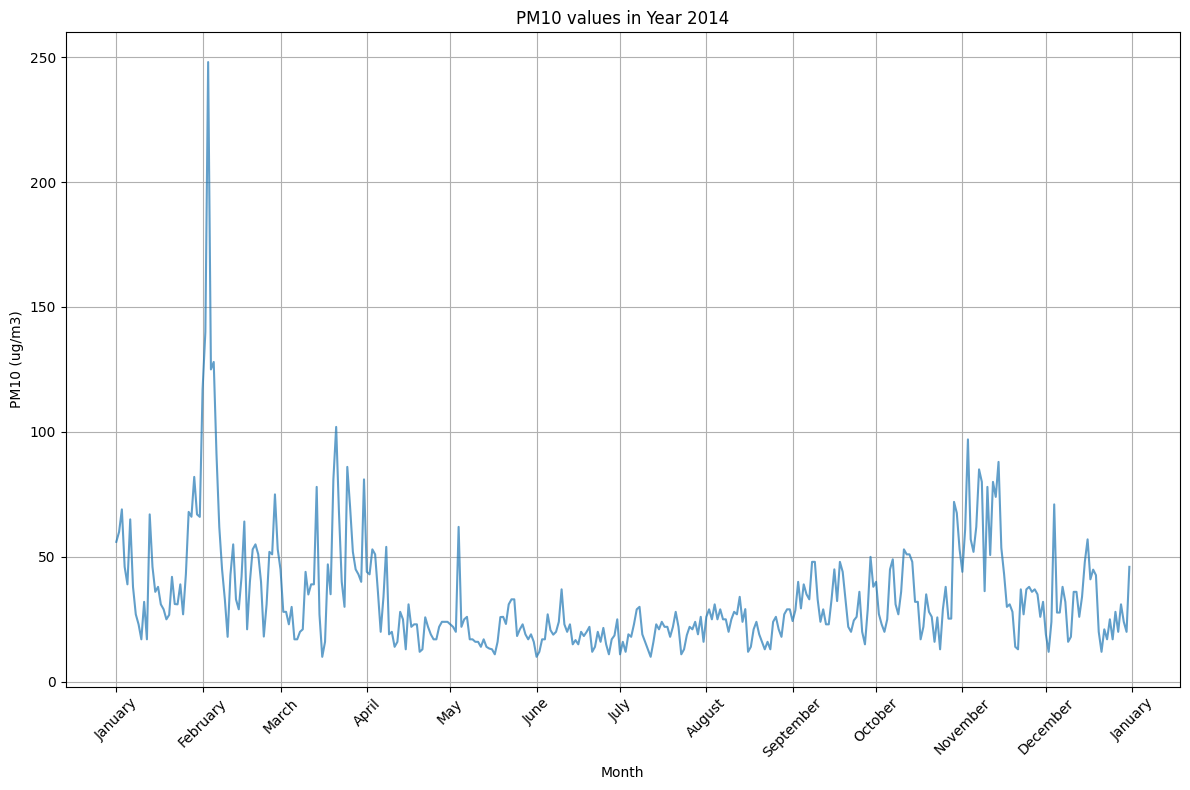

In [39]:
unique_years = df_imputed['Year'].unique()

for year in unique_years:
    plt.figure(figsize=(12, 8))
    plt.plot(df_imputed[df_imputed['Year']==year].index, df_imputed[df_imputed['Year']==year]['PM10'], alpha=0.7)
    plt.title(f"PM10 values in Year {year}")
    plt.xlabel("Month")
    plt.ylabel("PM10 (ug/m3)")
    
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))
    
    plt.grid(True)
    plt.xticks(rotation=45) 
    plt.tight_layout()
    plt.show()

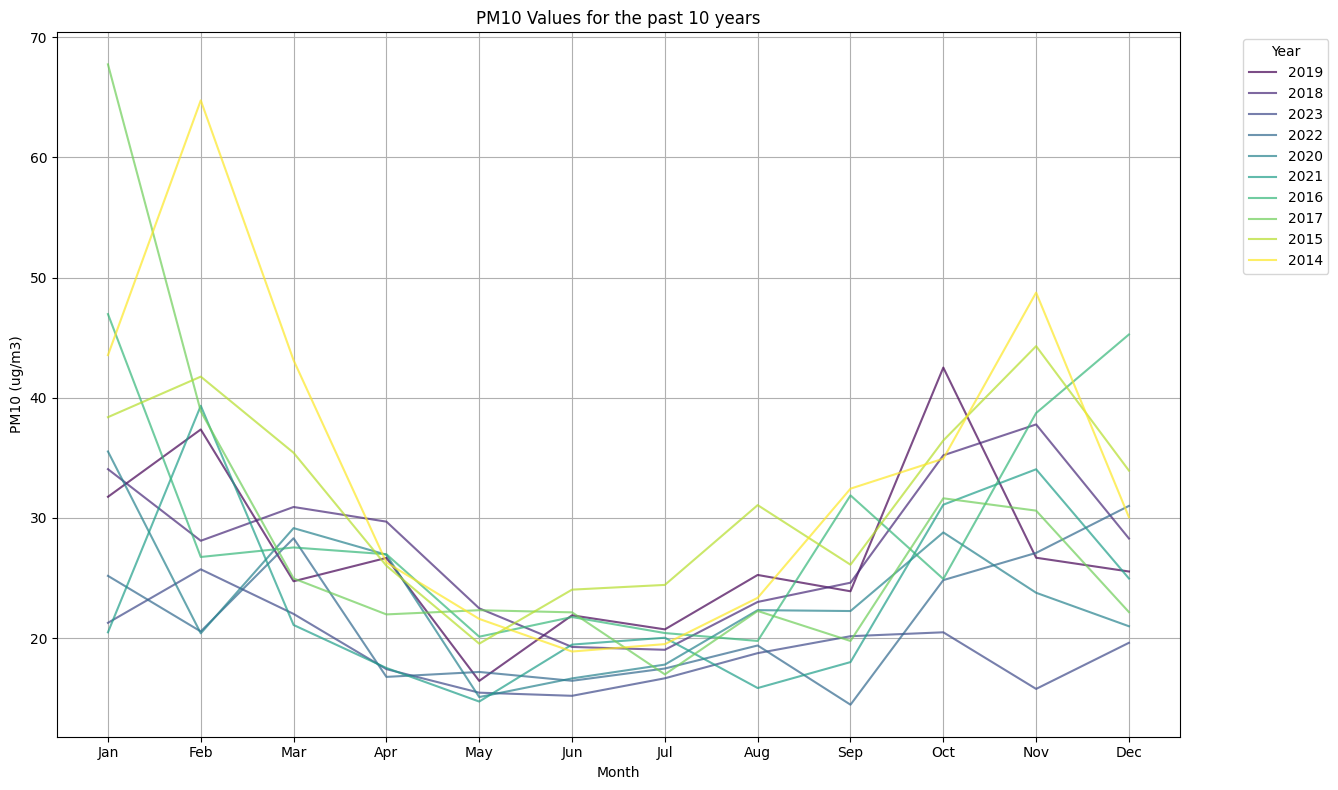

In [40]:
from matplotlib import cm

unique_years = df_imputed['Year'].unique()
months = np.arange(1, 13) 

plt.figure(figsize=(12, 8))

colors = cm.viridis(np.linspace(0, 1, len(unique_years)))

for i, year in enumerate(unique_years):
    monthly_data = df_imputed[df_imputed['Year'] == year].groupby('Month')['PM10'].mean()

    plt.plot(
        months, 
        monthly_data, 
        color=colors[i], 
        alpha=0.7, 
        label=f"{year}"
    )

plt.title("PM10 Values for the past 10 years")
plt.xlabel("Month")
plt.ylabel("PM10 (ug/m3)")

plt.xticks(months, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.grid(True)
plt.tight_layout()
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
